In [24]:
import pandas as pd
training_data = pd.read_csv('xxx')
validation_data = pd.read_csv('xxx')

# **Import dependencies**

In [25]:
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from torch.utils.data.dataset import Dataset
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

In [26]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords - converts the stopwords into a set which is faster in lookups
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # # Stemming
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(word) for word in tokens]

    # Rejoin tokens into a single string to return text (string)
    processed_text = ' '.join(tokens)

    return processed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [27]:
genre_counts = training_data[['comedy', 'cult', 'flashback', 'historical',
                     'murder', 'revenge', 'romantic', 'scifi', 'violence']].sum()

genre_counts_dict = genre_counts.to_dict()

print("Number of movies in each genre:")
for genre, count in genre_counts_dict.items():
    print(f"{genre}: {int(count)}")

Number of movies in each genre:
comedy: 1262
cult: 1801
flashback: 1994
historical: 186
murder: 4019
revenge: 1657
romantic: 2006
scifi: 204
violence: 3064


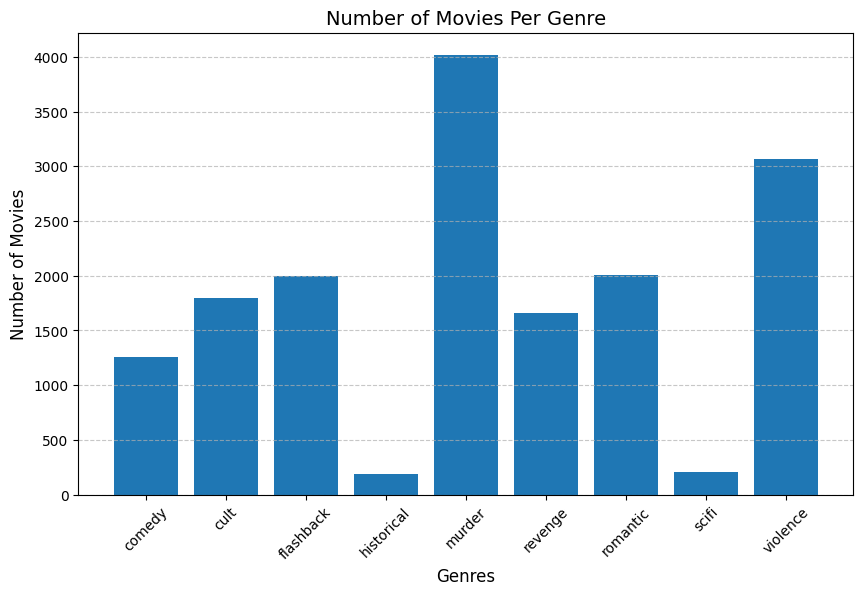

In [28]:
keys = list(genre_counts_dict.keys())
values = list(genre_counts_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(keys, values)

# Add labels and title
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.title('Number of Movies Per Genre', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [29]:
training_data['context']= training_data['title']+ ". " + training_data['plot_synopsis'].apply(preprocess_text)
validation_data['context']= validation_data['title']+ ". " + validation_data['plot_synopsis'].apply(preprocess_text)

In [30]:
train_df = training_data
val_df = validation_data

In [31]:
training_data.drop(['title', 'plot_synopsis'], axis=1, inplace=True)
validation_data.drop(['title', 'plot_synopsis'], axis=1, inplace=True)

In [32]:
training_data = training_data[['ID','context','comedy', 'cult', 'flashback', 'historical', 'murder', 'revenge', 'romantic', 'scifi', 'violence' ]]
validation_data = validation_data[['ID','context','comedy', 'cult', 'flashback', 'historical', 'murder', 'revenge', 'romantic', 'scifi', 'violence' ]]

In [33]:
# Extract the target columns (genre labels)
target_list = ['comedy', 'cult', 'flashback', 'historical', 'murder', 'revenge', 'romantic', 'scifi', 'violence']
y_train = training_data[target_list].values
y_validate = validation_data[target_list].values

In [34]:

# Hyperparameters
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 8
LEARNING_RATE = 1e-05

In [35]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [36]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = self.df['context']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }


In [37]:
custom_train_dataset = CustomDataset(train_df, tokenizer, 512)
custom_valid_dataset = CustomDataset(val_df, tokenizer, 512)

In [38]:
from torch.utils.data import WeightedRandomSampler
# Calculate sample weights
class_counts = training_data[target_list].sum(axis=0)  # Total count for each genre
sample_weights = training_data[target_list].dot(1 / class_counts.values)  # Weight for each sample

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(training_data),
    replacement=True
)

In [39]:
train_data_loader = torch.utils.data.DataLoader(custom_train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=sampler,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(custom_valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
print(f"Number of batches in val_data_loader: {len(val_data_loader)}")

Number of batches in val_data_loader: 38


In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [41]:
device

device(type='cuda')

In [42]:
# import shutil
# def load_ckp(checkpoint_fpath, model, optimizer):
#     """
#     checkpoint_path: path to save checkpoint
#     model: model that we want to load checkpoint parameters into
#     optimizer: optimizer we defined in previous training
#     """
#     # load check point
#     checkpoint = torch.load(checkpoint_fpath)
#     # initialize state_dict from checkpoint to model
#     model.load_state_dict(checkpoint['state_dict'])
#     # initialize optimizer from checkpoint to optimizer
#     optimizer.load_state_dict(checkpoint['optimizer'])
#     # initialize valid_loss_min from checkpoint to valid_loss_min
#     valid_loss_min = checkpoint['valid_loss_min']
#     # return model, optimizer, epoch value, min validation loss
#     return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

# def save_ckp(state, is_best, checkpoint_path, best_model_path):
#     """
#     state: checkpoint we want to save
#     is_best: is this the best checkpoint; min validation loss
#     checkpoint_path: path to save checkpoint
#     best_model_path: path to save best model
#     """
#     f_path = checkpoint_path
#     # save checkpoint data to the path given, checkpoint_path
#     torch.save(state, f_path)
#     # if it is a best model, min validation loss
#     if is_best:
#         best_fpath = best_model_path
#         # copy that checkpoint file to best path given, best_model_path
#         shutil.copyfile(f_path, best_fpath)

In [43]:

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 9)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss for multi-label classification.

        Args:
        - alpha: Weighting factor for class imbalance (default: 1).
        - gamma: Focusing parameter for hard examples (default: 2).
        - reduction: How to reduce the loss ('mean' or 'sum').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, outputs, targets):
        # Apply sigmoid to outputs
        outputs = torch.sigmoid(outputs)

        # Calculate focal loss
        BCE_loss = F.binary_cross_entropy(outputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [45]:
# create an instance of the focalLoss class
focal_loss_fn = FocalLoss(alpha=1, gamma=2, reduction='mean')
# BCEWithLogitsLoss combines sigmoid layer and the binary cross-entropy loss
def loss_fn(outputs, targets):
    return focal_loss_fn(outputs, targets)
    # return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [48]:
def train_model(n_epochs, training_loader, validation_loader, model, optimizer):
    """
    Train and validate the model while saving checkpoints for the best validation loss.
    """
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    # Store metrics for each epoch
    train_losses = []
    valid_losses = []

    for epoch in range(1, n_epochs + 1):
        # Initialize losses
        train_loss = 0.0
        valid_loss = 0.0

        # Training phase
        model.train()
        print(f"############# Epoch {epoch}: Training Start #############")

        for batch_idx, data in enumerate(training_loader):
            # Move data to device
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            # Forward pass
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

        # Calculate average training loss
        train_loss = train_loss / len(training_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch}: Training Loss = {train_loss:.6f}")

        # Validation phase
        model.eval()
        val_targets = []
        val_outputs = []

        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader):
                # Move data to device
                ids = data['input_ids'].to(device, dtype=torch.long)
                mask = data['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
                targets = data['targets'].to(device, dtype=torch.float)

                # Forward pass
                outputs = model(ids, mask, token_type_ids)
                loss = loss_fn(outputs, targets)

                # Accumulate validation loss
                valid_loss += loss.item()

                # Collect predictions and targets for evaluation
                val_targets.extend(targets.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        # Calculate average validation loss
        valid_loss = valid_loss / len(validation_loader)
        valid_losses.append(valid_loss)
        print(f"Epoch {epoch}: Validation Loss = {valid_loss:.6f}")

        print(f"############# Epoch {epoch} Done #############\n")

    # Return metrics for analysis
    return model, val_targets, val_outputs

In [49]:
trained_model,val_targets,val_outputs = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer)


############# Epoch 1: Training Start #############
Epoch 1: Training Loss = 0.138828
############# Epoch 1: Validation Start #############
Epoch 1: Validation Loss = 0.107893
############# Epoch 1 Done #############

############# Epoch 2: Training Start #############
Epoch 2: Training Loss = 0.118370
############# Epoch 2: Validation Start #############
Epoch 2: Validation Loss = 0.103774
############# Epoch 2 Done #############

############# Epoch 3: Training Start #############
Epoch 3: Training Loss = 0.103969
############# Epoch 3: Validation Start #############
Epoch 3: Validation Loss = 0.106205
############# Epoch 3 Done #############

############# Epoch 4: Training Start #############
Epoch 4: Training Loss = 0.093587
############# Epoch 4: Validation Start #############
Epoch 4: Validation Loss = 0.104835
############# Epoch 4 Done #############

############# Epoch 5: Training Start #############
Epoch 5: Training Loss = 0.081913
############# Epoch 5: Validation Start ##

In [50]:
validation_dataa = pd.read_csv('/content/CW2-validation-dataset.csv')

In [51]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Convert val_outputs and val_targets to NumPy arrays
val_outputs = np.array(val_outputs)  # Model probabilities
val_targets = np.array(val_targets)  # True labels

# Initialize list to store the best thresholds
best_thresholds = []

# Loop through each genre
for i in range(len(target_list)):
    # Get probabilities and true labels for the current genre
    probs = val_outputs[:, i]
    true_labels = val_targets[:, i]

    # Calculate Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(true_labels, probs)

    # Calculate F1-score for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Avoid division by zero

    # Find the threshold that gives the maximum F1-score
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Store the best threshold
    best_thresholds.append(best_threshold)

    # Print details
    print(f"Genre: {target_list[i]}")
    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1-Score: {f1_scores[best_idx]:.4f}\n")

# Output all best thresholds
print("Best Thresholds for All Genres:", best_thresholds)

Genre: comedy
Best Threshold: 0.3580
Best F1-Score: 0.4394

Genre: cult
Best Threshold: 0.4016
Best F1-Score: 0.5043

Genre: flashback
Best Threshold: 0.3721
Best F1-Score: 0.5067

Genre: historical
Best Threshold: 0.2087
Best F1-Score: 0.1905

Genre: murder
Best Threshold: 0.4298
Best F1-Score: 0.7621

Genre: revenge
Best Threshold: 0.5525
Best F1-Score: 0.4593

Genre: romantic
Best Threshold: 0.4280
Best F1-Score: 0.6440

Genre: scifi
Best Threshold: 0.4548
Best F1-Score: 0.4444

Genre: violence
Best Threshold: 0.3636
Best F1-Score: 0.6898

Best Thresholds for All Genres: [0.35795003175735474, 0.40158286690711975, 0.3720724880695343, 0.2086649090051651, 0.4297981560230255, 0.5524688959121704, 0.42797425389289856, 0.45476797223091125, 0.3636344373226166]


In [52]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

# Assume you already have val_outputs (predicted probabilities), val_targets (true labels),
# and best_thresholds (array of thresholds for each genre).

# Convert val_outputs to binary predictions using the best thresholds for each genre
binary_predictions = np.zeros_like(val_outputs, dtype=int)  # Initialize binary predictions as integers
for i in range(len(target_list)):  # len(target_list) = 9 (number of genres)
    binary_predictions[:, i] = (val_outputs[:, i] > best_thresholds[i]).astype(int)

# Convert true_targets to integers
true_targets = np.array(val_targets, dtype=int)

# Calculate metrics
print("Classification Report with Optimized Thresholds:")
print(classification_report(true_targets, binary_predictions, target_names=target_list, zero_division=0))

# Calculate specific metrics
macro_f1 = f1_score(true_targets, binary_predictions, average='macro')
micro_f1 = f1_score(true_targets, binary_predictions, average='micro')
precision = precision_score(true_targets, binary_predictions, average='macro')
recall = recall_score(true_targets, binary_predictions, average='macro')

print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Save predictions to CSV
# Create DataFrame with predictions
output_df = pd.DataFrame(binary_predictions, columns=target_list)

# Add the 'ID' column if available in the validation dataset
output_df.insert(0, 'ID', validation_dataa['ID'])

# Save predictions to CSV, excluding the header row
output_df.to_csv('validation_predictions.csv', index=False, header=False)
print("Predictions saved to 'validation_predictions.csv'")

Classification Report with Optimized Thresholds:
              precision    recall  f1-score   support

      comedy       0.36      0.54      0.44       175
        cult       0.43      0.60      0.50       247
   flashback       0.45      0.58      0.50       294
  historical       0.12      0.29      0.17        24
      murder       0.67      0.88      0.76       581
     revenge       0.44      0.47      0.46       237
    romantic       0.67      0.62      0.64       290
       scifi       0.42      0.42      0.42        31
    violence       0.57      0.87      0.69       420

   micro avg       0.53      0.70      0.60      2299
   macro avg       0.46      0.59      0.51      2299
weighted avg       0.54      0.70      0.61      2299
 samples avg       0.54      0.71      0.57      2299

Macro F1-Score: 0.5086
Micro F1-Score: 0.6042
Precision: 0.4591
Recall: 0.5854
Predictions saved to 'validation_predictions.csv'


In [64]:
import pandas as pd
import numpy as np
import torch


# Load the test dataset
test_data = pd.read_csv('/content/CW2-test-dataset.csv')

# Assign column names manually
test_data.columns = ['ID', 'movie_name', 'Description']

# Preprocess the test data
test_data['context'] = (test_data['movie_name'] + ". " + test_data['Description']).apply(preprocess_text)

# Tokenize and pad the test data
test_contexts = test_data['context'].tolist()
test_sequences = tokenizer.batch_encode_plus(
    test_contexts,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Create DataLoader for test data
test_dataset = torch.utils.data.TensorDataset(
    test_sequences['input_ids'],
    test_sequences['attention_mask'],
    test_sequences['token_type_ids']
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

# Ensure the model is in evaluation mode
model.eval()

# Generate predictions for the test data
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        outputs = model(input_ids, attention_mask, token_type_ids)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        test_predictions.extend(probabilities)

test_predictions = np.array(test_predictions)
# Convert predictions to binary using the best thresholds
binary_predictions = np.zeros_like(test_predictions, dtype=int)
for i, threshold in enumerate(best_thresholds):
    binary_predictions[:, i] = (test_predictions[:, i] > threshold).astype(int)

# Create output DataFrame
output_df = pd.DataFrame(binary_predictions, columns=target_list)
output_df.insert(0, 'ID', test_data['ID'])

# Save predictions to a CSV file
output_file = '10953347_task2_code.csv'
output_df.to_csv(output_file, index=False, header=False)
print(f"Predictions saved to '{output_file}'")

Predictions saved to 'test_output_task2.csv'
